# This Notebook is desigend to be run in Google Colab. Click the badge below:
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxNaeg/SciExpColab/blob/main/example_define_new_simulator_analysis.ipynb)

# Install SciExplorer

In [1]:
import sys
!{sys.executable} -m pip install git+https://github.com/MaxNaeg/SciExplorer

  Cloning https://github.com/MaxNaeg/SciExplorer to /private/var/folders/bl/g1q9c8kd65d4_zy09smb8lgdfdw6x5/T/pip-req-build-_xfti3ge
  Running command git clone --filter=blob:none --quiet https://github.com/MaxNaeg/SciExplorer /private/var/folders/bl/g1q9c8kd65d4_zy09smb8lgdfdw6x5/T/pip-req-build-_xfti3ge
  Resolved https://github.com/MaxNaeg/SciExplorer to commit b73a0212bfd37d47158d6acf0c3a65fbcd7df305
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# clone repo to use helper functions and classes
!git clone https://github.com/MaxNaeg/SciExpColab.git
%cd SciExpColab

# Example of creating a new system from scratch
In this notebook we show how to add a new experiment (in this case simulated) and analysis tools to the framework. We consider a biological system governed by predator-prey dynamics.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sciexplorer.tool_utils import get_image # this function is needed to return images to the agent
from sciexplorer.model_utils import Model
from sciexplorer.run_exp import run_experiment
from tool_utils import exec_with_error_line

## Creating an experiment
We will define an experiment where the agent is asked to do symbolic regression

In [3]:
# Helper function to evaluate proposed functions. No need to understand this in detail.
def _evaluate_function(function_code:str, x_data:np.ndarray, y_data:np.ndarray) -> float: 
    # Start of generic block to execute some code written by the agent
    globals_dict = {'symbolic_function':None, 'np':np,} # define packages and variables that should be accessible
    globals_dict = exec_with_error_line(function_code, globals_dict)
    proposed_function = globals_dict['symbolic_function']
    if proposed_function is None:
        raise ValueError("The code did not define symbolic_function.")
    if not callable(proposed_function):
        raise ValueError("The symbolic_function variable must be callable.")
    try:
        y_pred = proposed_function(x_data)
        MSE = np.mean((y_pred - y_data)**2)
    except Exception as e:
        raise ValueError(f"An error occurred when calling the symbolic_function: {e}")
    # End of generic block to execute some code written by the agent
    return MSE

In [ ]:
class SymregExp():
    def __init__(self, x_data:np.ndarray, y_data:np.ndarray, x_test:np.ndarray, y_test:np.ndarray):
        self.x_data = x_data # data for the agent
        self.y_data = y_data # data for the agent
        self.x_test = x_test # data for final evaluation
        self.y_test = y_test # data for final evaluation
        self.last_result = {}
        # Description shown to the agent, in this case, we don't need any additional description beyond the tool docstrings.
        self.description = ""     

    # This is a tool. Its docstring and typehints will be automatically parsed to create the tool description for the agent.
    # Tools always need to return dictionaries!
    def get_data(self) -> dict:
        '''Returns the data you should fit. Always call this in your first step.'''
        # Every tool result will be available to the agent in subsequent steps in the execute_code and plot_from_code tools.
        return {'x_train': self.x_data, 'y_train': self.y_data}
    
    def evaluate_function(self, function_code:str) -> dict:
        """Evaluate a proposed symbolic function on the training data.
        Args:
            function_code: code defining a function 'def symbolic_function(x: np.ndarray) -> np.ndarray' which should
            use numpy code (e.g. np.sin(x)*x**2) and return y values for in input array of y values.
        Returns:
            The mean squared error (MSE) of the proposed function on the training data."""
        MSE = _evaluate_function(function_code, self.x_data, self.y_data)
        return {'MSE': MSE}

    # If the agent calls this special tool, the experiment will end. 
    def save_result(self, function_code:str) -> dict:
        """Save your final result. Only call this at the end of your exploration, when you cannot improve the result anymore.
        Args:
            function_code: code defining a function 'def symbolic_function(x: np.ndarray) -> np.ndarray' which should
            use numpy code (e.g. np.sin(x)*x**2) and return y values for in input array of y values.
        Returns:
            Message that the result has been saved."""
        try:
            MSE_test = _evaluate_function(function_code, self.x_test, self.y_test)
            MSE_train = _evaluate_function(function_code, self.x_data, self.y_data)
            self.last_result = {'function_code': function_code, 'MSE_test': MSE_test, 'MSE_train': MSE_train, 'error': None}
        except Exception as e:
            self.last_result = {'function_code': function_code, 'MSE_test': np.nan, 'MSE_train': np.nan, 'error': str(e)}
        return {'result_message': 'saved result'}

In [5]:
# Define Exoeriment object
def func_to_fit(x):
    return np.sin(2.0 * x) + 0.3 * x

x_data = np.linspace(-5, 5, 50)
y_data = func_to_fit(x_data)

x_test = np.linspace(-10, 10, 1000)
y_test = func_to_fit(x_test)
experiment = SymregExp(x_data, y_data, x_test, y_test)

# Creating an analysis tool

In [6]:
# We import generic tools to execute arbitrary code and create plots from code.
# You may add additional custom tools here if needed in the same style as the above tools (but as stand-alone functions).
from tools import execute_code, plot_from_code
analysis_tools = [execute_code, plot_from_code]

# Running the experiment

In [14]:
# create the LLM model
model = Model(
    api_key = '',  # add your OpenAI API key here
    base_url=None,
    model_name='gpt-5-mini', # use 'gpt-5' for better performance and 'gpt-5-mini' for debugging/easier tasks
)

AuthenticationError: Error code: 401 - {'error': {'message': "You didn't provide an API key. You need to provide your API key in an Authorization header using Bearer auth (i.e. Authorization: Bearer YOUR_KEY), or as the password field (with blank username) if you're accessing the API from your browser and are prompted for a username and password. You can obtain an API key from https://platform.openai.com/account/api-keys.", 'type': 'invalid_request_error', 'param': None, 'code': None}}

In [8]:
system_promt = """You are a cautious theoretical physicists.
You plot data before fitting functions to it and carefully evaluate proposed functions.
<tool_preambles>
Before calling tools:
- Describe why you want to call the tool and what you expect to learn from it.
</tool_preambles>"""

task_prompt = """Can you find an analytical expression that fits the provided data points well?"""

--Setting simulator tools: [<bound method SymregExp.get_data of <__main__.SymregExp object at 0x104239250>>, <bound method SymregExp.evaluate_function of <__main__.SymregExp object at 0x104239250>>]--
--Setting analysis tools: [<function execute_code at 0x1290dff60>, <function plot_from_code at 0x1290f85e0>]--
--Running experiment--
Timeout for function calls set to: 30
SYSTEM: You are a cautious theoretical physicists.
You plot data before fitting functions to it and carefully evaluate proposed functions.
<tool_preambles>
Before calling tools:
- Describe why you want to call the tool and what you expect to learn from it.
</tool_preambles>
USER: 
Can you find an analytical expression that fits the provided data points well?
You can reason for up to 20 steps and call up to 40 tools to help you find the answer.
After your exploration please call the tool save_result to provide your final answer.
USER: 
 You potentially have up to 20 steps left and can call up to 40 tools. If already pres

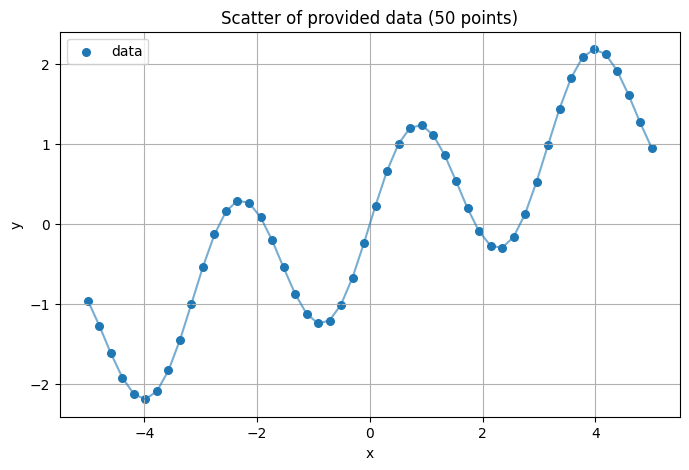

TOOL fc_0fc3d9d91dd19f7e006967a87adfc8819e8a008dc207a7bd89: Saved the following results in the format <result_label>: <result>:
plot1_image: Image data is provided later by the user.
USER: Here's the image plot1_image generated by the tool:
-- Image sent--
USER: 
 You potentially have up to 18 steps left and can call up to 38 tools. If already present, what do the past tool results teach you about the question?
Describe which tool you want to call next and why you want to call it in plain text.
ASSISTANT REASONING: **Evaluating data trends**

I'm approaching this like a cautious theoretical physicist, focusing on plotting data before fitting any functions. It looks like the x-values range from -5 to 5, with about 50 points, incrementing by 0.2. The y-values show an oscillatory pattern with a possibly upward linear trend. I'm observing that the y-value at x=-5 might be around -0.95. I need to inspect that more carefully for accuracy.
ASSISTANT RESPONSE: The scatter plot shows a clear os

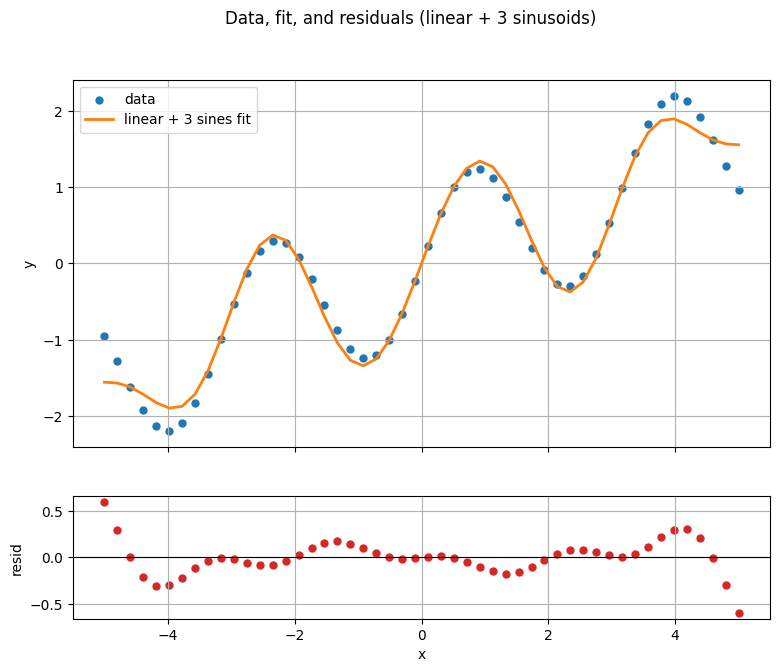

TOOL fc_0fc3d9d91dd19f7e006967a8e3597c819e84630eb040807a26: Saved the following results in the format <result_label>: <result>:
plot_fit_resid_image: Image data is provided later by the user.
USER: Here's the image plot_fit_resid_image generated by the tool:
-- Image sent--
USER: 
 You potentially have up to 15 steps left and can call up to 35 tools. If already present, what do the past tool results teach you about the question?
Describe which tool you want to call next and why you want to call it in plain text.
ASSISTANT REASONING: **Evaluating theoretical data**

I need to approach this like a cautious theoretical physicist. I'll evaluate the previous results, noting that data shows an oscillatory pattern with a linear trend. The FFT revealed a top frequency around 0.294, while others are at 0.392 and 0.49. The linear trend with sine functions indicates specific coefficients corresponding to each, including an intercept near zero and various amplitudes. For instance, the amplitude fo

({'function_code': 'def symbolic_function(x: np.ndarray) -> np.ndarray:\n    import numpy as np\n    return (\n        -1.23309327046977e-16 + 0.3*x\n        + 0.999999999999994*np.sin(2*np.pi*0.318309886183791*x + 2.5804588657334e-16)\n        + 0.0387365329820731*np.sin(2*np.pi*0.357985402366373*x + -3.38941706623807e-05)\n        + 0.0387365329820674*np.sin(2*np.pi*0.357985402366376*x + -3.14162654776045)\n    )\n',
  'MSE_test': np.float64(1.7382265812086199e-28),
  'MSE_train': np.float64(4.5153704880070737e-29)},
 [{'role': 'system',
   'content': 'You are a cautious theoretical physicists.\nYou plot data before fitting functions to it and carefully evaluate proposed functions.\n<tool_preambles>\nBefore calling tools:\n- Describe why you want to call the tool and what you expect to learn from it.\n</tool_preambles>'},
  {'role': 'user',
   'content': '\nCan you find an analytical expression that fits the provided data points well?\nYou can reason for up to 20 steps and call up to
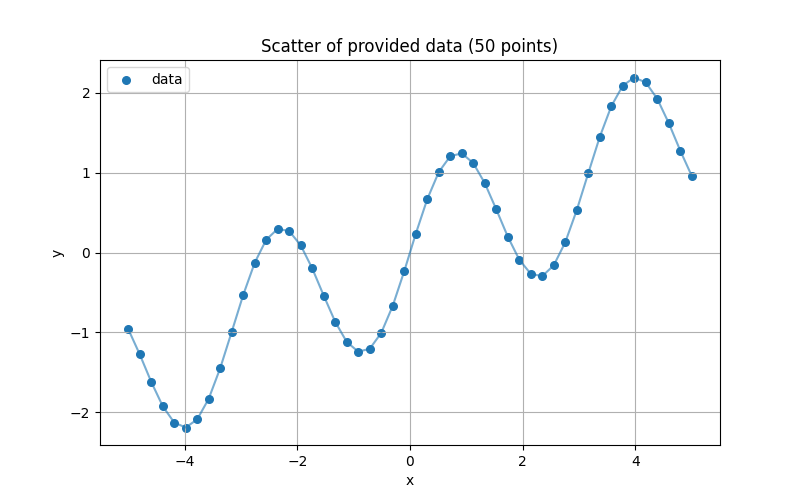
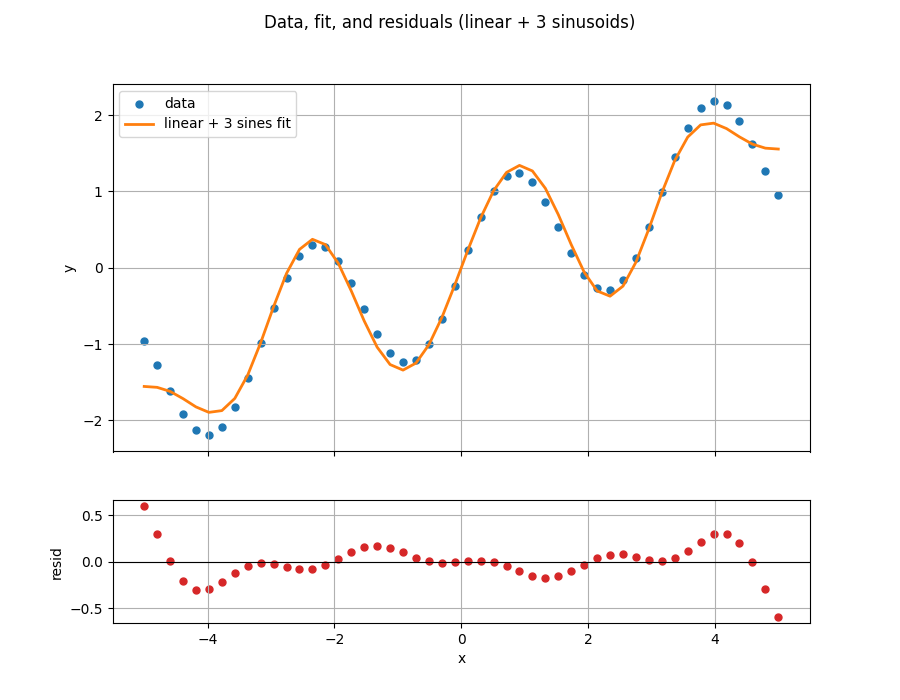
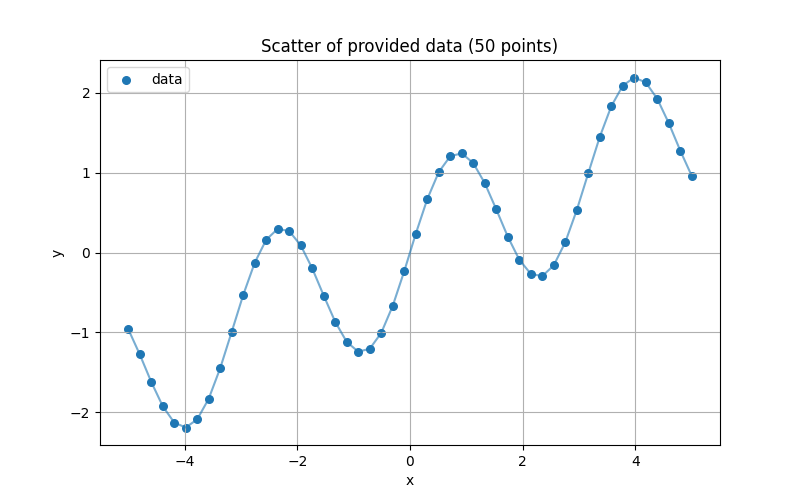
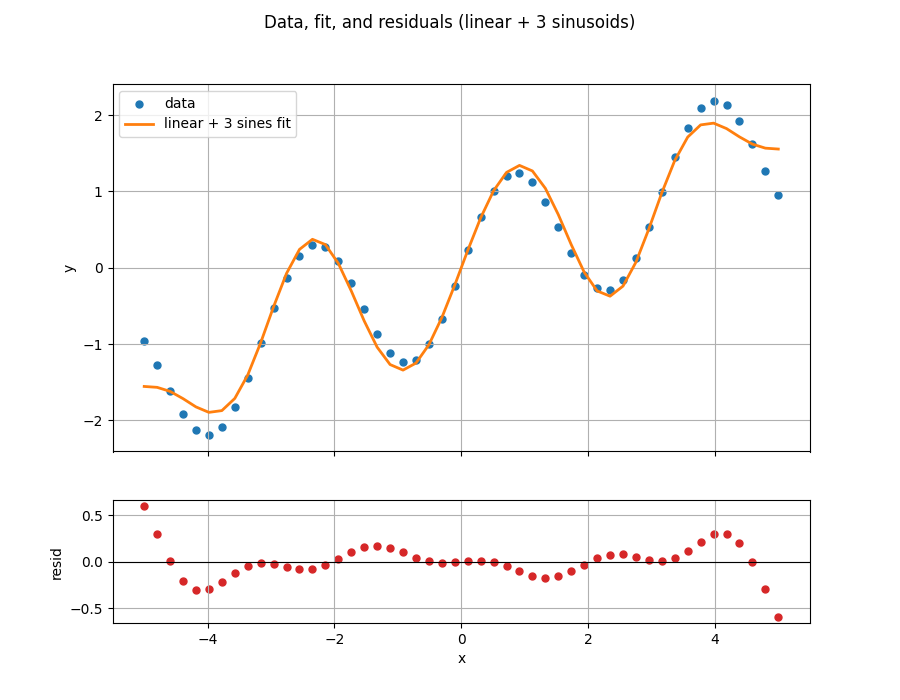

In [9]:
run_experiment(model=model,
                task_prompt=task_prompt,
                simulator=experiment, # initialized simulator object
                simulator_tools = ['get_data', 'evaluate_function'], # the tools of the simulator that the agent can use as strings
                analysis_tools = analysis_tools, # the analysis tools that the agent can use, here we pass the function directly
                run_kwargs=dict(
                            allow_multiple_tool_calls = True, # allow the agent to call multiple tools in one step
                            max_steps = 20, max_tools = 40 # maximum number of steps and tools the agent can use in one run
                            ),
                result_tool = "save_result", # the tool to save the final result should be a method of the simulator
                system_prompt= system_promt, # system prompt for the agent 
                intermediate_prompts={'ask_for_reasoning': {"content": f"""If already present, what do the past tool results teach you about the question?
Describe which tool you want to call next and why you want to call it in plain text."""},
                                       'ask_for_tool_use': {"content": """THIS IS NOT NEEDED IF separate_tool_calls=False."""},
                                        'wrong_format_tool_call': {"content": """THIS IS NOT NEEDED IN RESPONSE API."""},
                                        'ask_final_answer': {"content": f"""Please provide a final answer without using any tools."""}},
                summarize_at_end=True, # summarize the experiment at the end of the run
                separate_tool_calls=False, # Whether to separate tool calls from reasoning steps
                response_api=True, # Use the response API or ChatCompletion API
                reasoning_level="high", # Level of reasoning to use: low, medium, high
                verbosity="high", # Level of verbosity: low, medium, high
                reasoning_summary="auto", # Create summary of internal reasoning at each step
                timeout=30, # timeout for each tool evaluation in seconds
                random_exp_func=None, # no needed, ignore
                plot_function=None, # no needed, ignore
                n_exps_to_run= 0, # no needed, ignore
)

# An alternative experiment for discovering equations of motion:

In [12]:
class BlackBoxSystem():
    """Lotka-Volterra system describing predator-prey dynamics as black box simulator."""
    
    def __init__(self, a=1.0, b=0.1, c=1.5, d=0.075, dt=0.1, num_steps=1000, steps_per_timestep=10):
        self.a = a  # Prey growth rate
        self.b = b  # Predation rate
        self.c = c  # Predator death rate
        self.d = d  # Predator reproduction rate
        self.dt = dt # Time step for integration
        self.num_steps = num_steps # Number of time steps to simulate
        # The description will be shown to the agent when initializing the experiment
        self.description = "In this system, you can observe the population dynamics of two species in an experimental biological system."
        self.steps_per_timestep = steps_per_timestep # Number of internal solver steps per time step (not used in this simple Euler method)

    def step(self, state):
        """Perform one time step using Euler's method."""
        prey, predator = state
        for _ in range(self.steps_per_timestep):
            dprey = (self.a * prey - self.b * prey * predator) * (self.dt / self.steps_per_timestep)
            dpredator = (self.d * prey * predator - self.c * predator) * (self.dt / self.steps_per_timestep)
            prey += dprey
            predator += dpredator
        return np.array([prey, predator])
    
    def observe_dynamics(self, init0:float, init1:float) -> dict:
        # This is a tool. Its docstring and typehints will be automatically parsed to create the tool description for the agent.
        # Therefore, we cannot provide any hints about the system here.
        # Additionally, the final tool description will automatically ask the agent to provide a label under which the result should be saved.
        # Tools always need to return dictionaries!
        """Observe the dynamics of the system given initial conditions.
        Args:
            init0: Initial condition one.
            init1: Initial condition two
        Returns:
            states (np.ndarray): Array containing the states at each time step.
            times (np.ndarray): Array containing the time points.
        """
        states = [np.array([init0, init1])]
        for _ in range(self.num_steps):
            new_state = self.step(states[-1])
            states.append(new_state)
        return {"states": np.array(states), "times": np.arange(len(states))*self.dt}
    
    def save_result(self, result:str) -> dict:
        # This is a tool. Its docstring and typehints will be automatically parsed to create the tool description for the agent.
        # As above, the tool needs to return a dictionary.
        """Save your predicted equation of motion for the system.
        Args:
            result: python code as a string the defines the following function:
                def equation_of_motion(state: np.ndarray) -> np.ndarray:
                    # state is a numpy array of shape (2,) containing the current state [s0, s1]
                    # The function should return a numpy array of shape (2,) containing the time derivative [ds0/dt, ds1/dt]
                    return np.array([ds0_dt, ds1_dt])
        Returns:
            Message that the result was saved.
        """
        # You may add some code to automaticcally validate the result here.
        self.last_result = {"predicted_eom": result}
        return {"message": "Result saved successfully."}



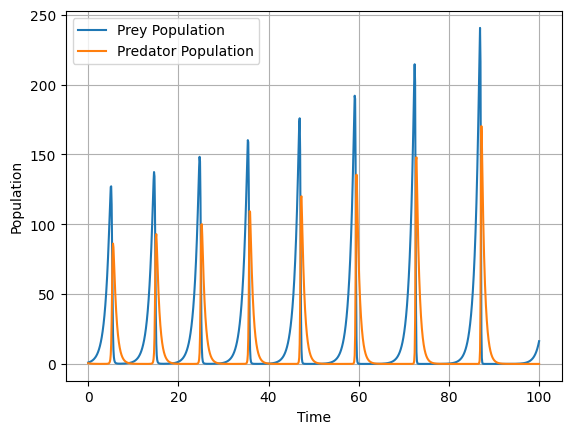

In [13]:
experiment = BlackBoxSystem()
dynamics = experiment.observe_dynamics(1,0.5)

plt.plot(dynamics['times'], dynamics['states'][:,0], label='Prey Population')
plt.plot(dynamics['times'], dynamics['states'][:,1], label='Predator Population')
plt.xlabel('Time')
plt.ylabel('Population')
plt.grid(True)
plt.legend()
plt.show()
